## 深度学习面临的挑战 

1. model size
2.  speed
3. Energy Efficiency
    where is the 


2. Improve the Efficiency of Deep Learning by Algorithm-Hardware Co-Design 

通过算法和硬件的联动设计改进深度学习

### 一.硬件介绍

- CPU:延时导向，单线程
- GPU：吞吐量导向，有多个小线程
- FPGA： 可编程硬件，逻辑可以改变，效率不高，介于通用硬件和纯ASIC之间
- ASIC：特定用途集成电路，固定逻辑，为特定用途设计的，如Google专门为DL设计的**TPU**。

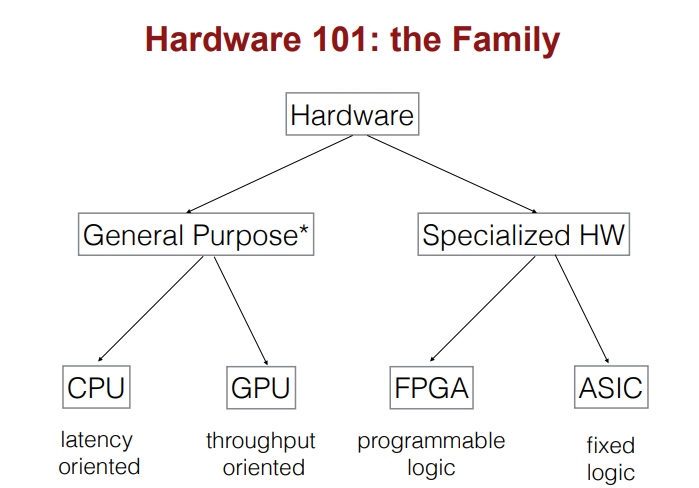

### 1.2 数字表示

计算机中的数字并非连续表示的，他们是离散表示的，如下图所示。$S$为指数位，$E$为数位，$M$为尾数位。

$int8$是谷歌TPU使用的数据类型，用整数表示定点数。

为什么人们喜欢8位/16位而不爱32浮点位？ 因为计算开销，如图2所示32-16节约了能耗

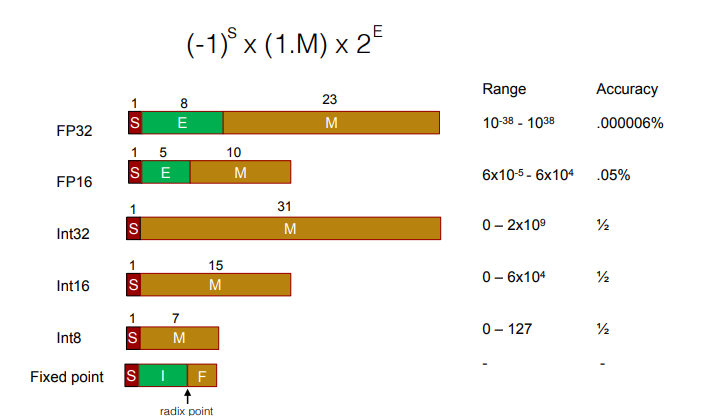
**<center> 图1. 数字的计算机表示<center>**

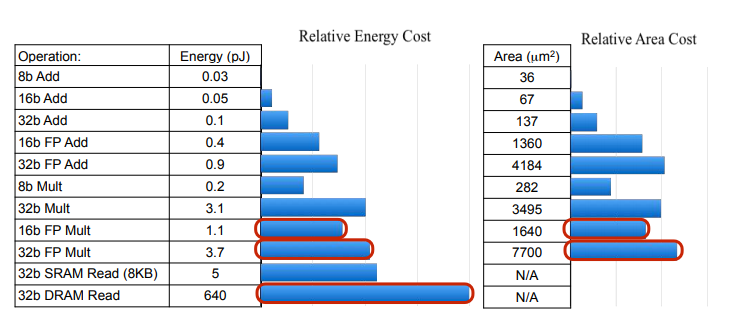
**<center> 图2. 不同数据类型的能耗<center>**

### 二. Algorithm for Efficient Interface 高效的前向推断算法，节约内存

#### 2.1 Pruning Neural Network 对网络剪枝

裁剪冗余的权重，裁剪后重新训练。
如何剪枝？ 权重设为0？

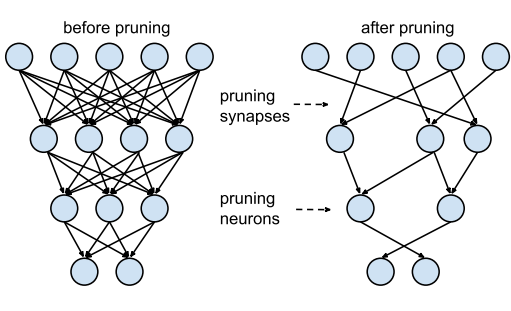
**<center> 图1. 剪枝图解<center>**

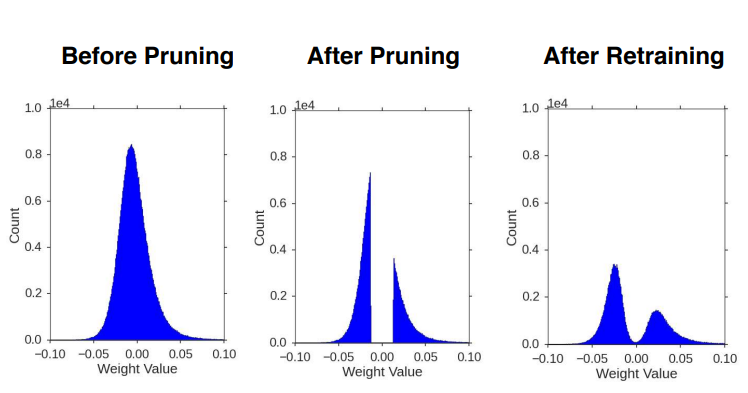
**<center> 图2. 剪枝后的权重分布<center>**

#### 2.2 Weight sharing 权值共享

想法：1.89， 2.09，2.12这些数都可以用2.0 表达，过于精确可能会导致过拟合。

方法： 如下图对权重做**K-means**聚类

如何训练这样的网络：对权重做聚类后标记颜色，对同类的梯度求和后$*lr$ 做$w = w - lr*grad$

通过这些操作，权重会变成如图2所示的离散分布，因为权值做了聚类，可以用更少的位数去表示权值

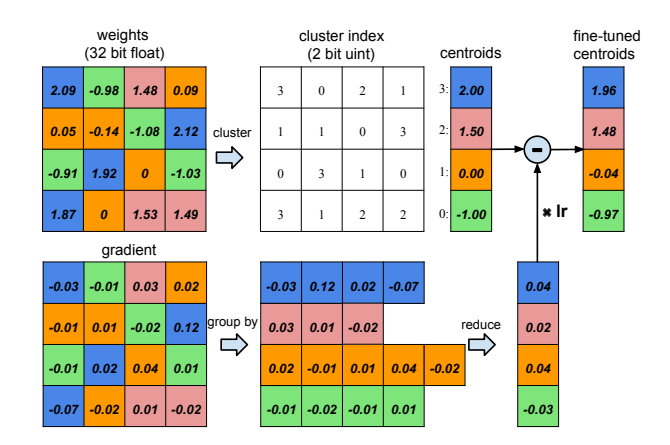
**<center> 图1. 权值共享过程<center>**

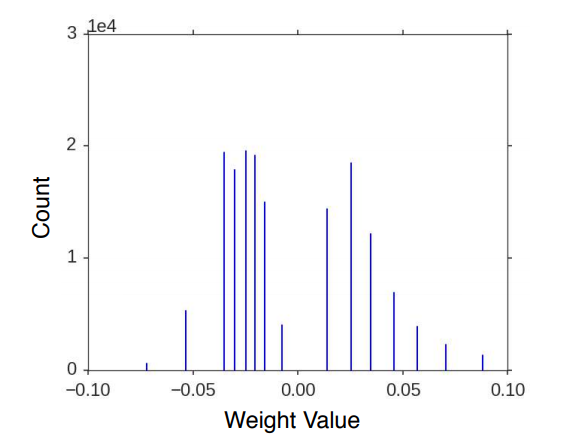
**<center> 图2. 共享后的权重分布<center>**

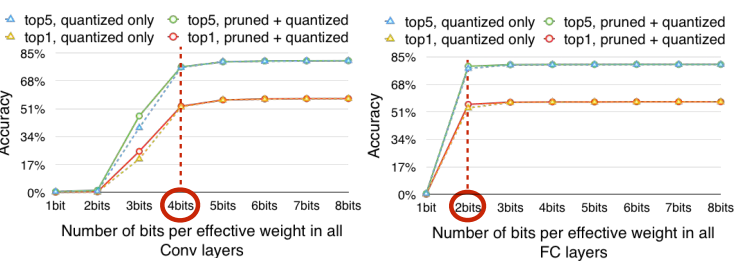
**<center> 图3. 权值位数对准确率的影响<center>**

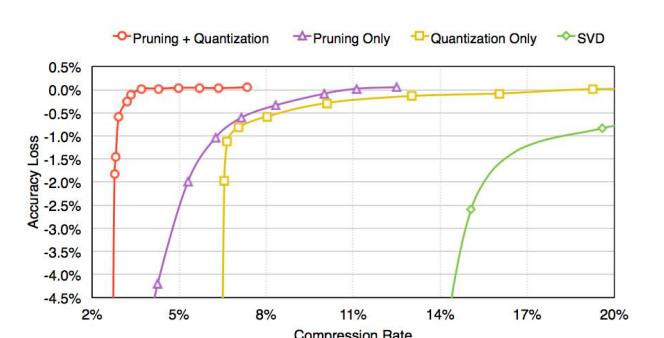
**<center> 图4. 不同优化方法的对比，结合权值共享和剪枝的效果比单独使用更好<center>**

### 2.3 Huffman Coding 霍夫曼编码

思想：用更多的位数表示不常出现的权重，更少的位数表示常出现的权重

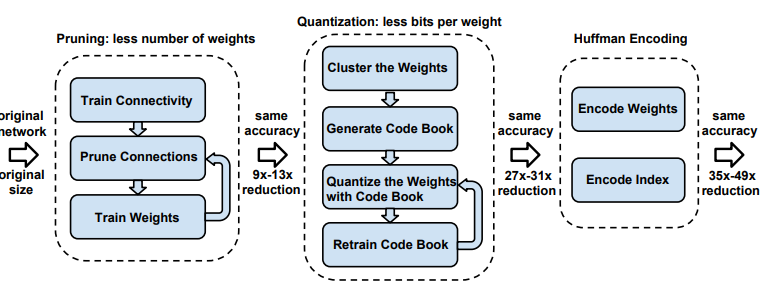

### 2.4 SqueezeNet

前面都是对已有的，已经训练的网络进行修建压缩，Squeeze从设计上就开始缩减尺寸。
对squeezeNet进行压缩后的表现率依旧很好

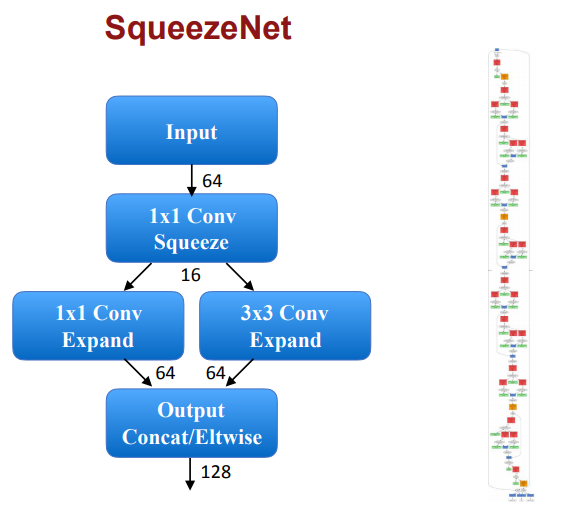
**<center> 图1. squeezeNet的结构<center>**

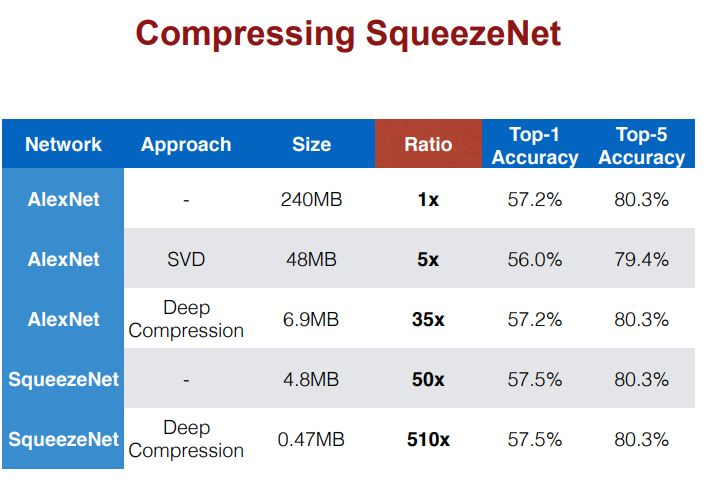
**<center> 图1. squeezeNet压缩实验<center>**

### 2.5 Quatization 量化理论，广泛用于TPU设计
- pruning 和 weight sharing 都是非线性的量化方法
- TPU仅仅使用8位做推断

量化理论的原理

1. 用标准浮点数训练NN，通过收集每一层的统计信息来量化权重和激活值。量化值：最大最小值，多少位数字能足以表达这个动态范围。然后用这么多位数表示整数部分，用剩下几位表示其他的部分。
2. 也可以微调浮点数，用定点数前向，float反向传播并更新权重

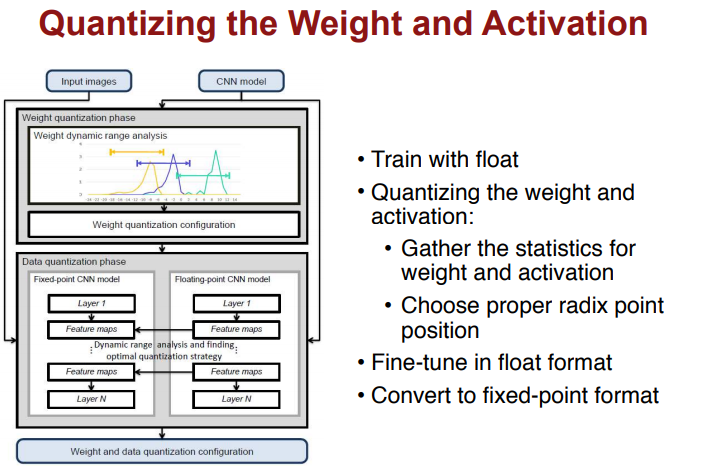
**<center> 图1. 量化理论原理<center>**

###  2.6 Low Rank Approximation 低秩近似

- 思想是将一步卷积拆分位多步卷积
- 对FC，利用矩阵分解将一个矩阵拆分成两个矩阵

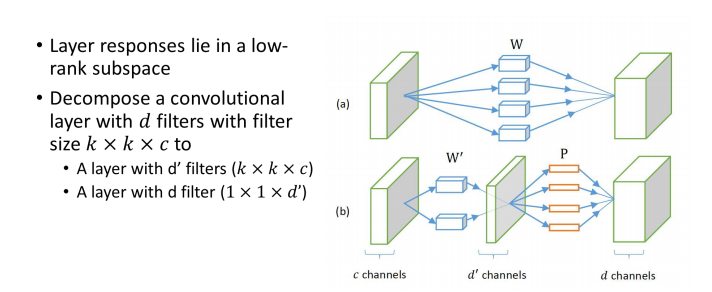
**<center> 图1. 卷积的低秩近似<center>**

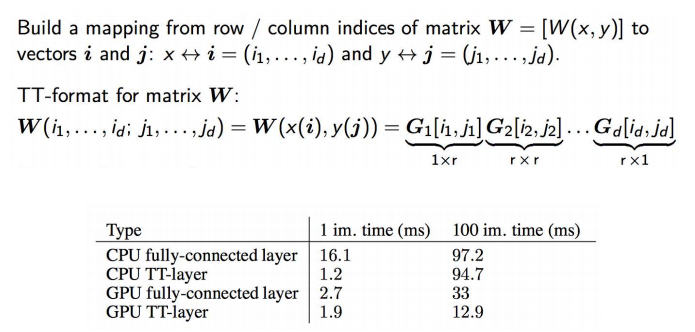
**<center> 图2. FC的低秩近似<center>**

### 2.6 Binary/Ternary Network

思想是只用2个或者三个权值去表现NN

### 2.7 WINOGRAD Convolution

使用另外一种卷积方法来减少计算次数。cuDNN5后就开始用WINOGRAD Convolution代替传统卷积

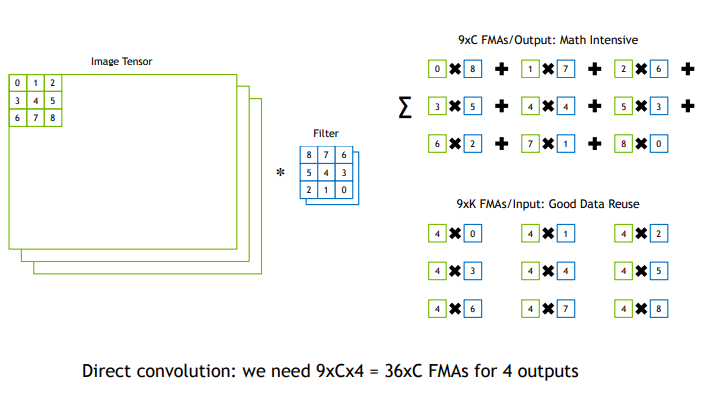

**<center> 图1. 传统的3*3卷积步骤<center>**

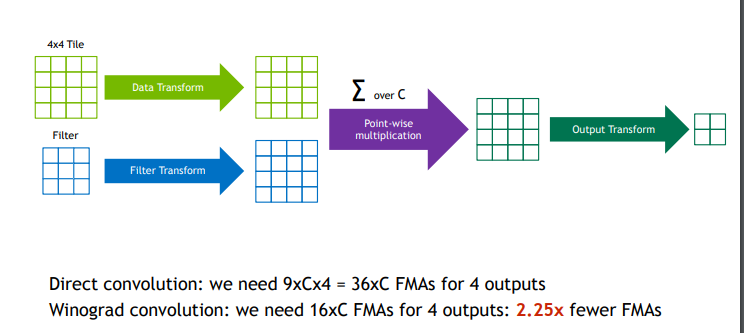
**<center> 图1. WINOGRAD Convolution步骤<center>**

### 三. Hardware for Efficient Interface 高效的前向硬件

高效硬件的共同目标是，减少内存访问，进而减少耗能
- Google TPU
- EIE ：专门用于处理稀疏压缩过的模型的硬件，进而节省存储带宽。思想：稀疏权重，近似表示，权值共享

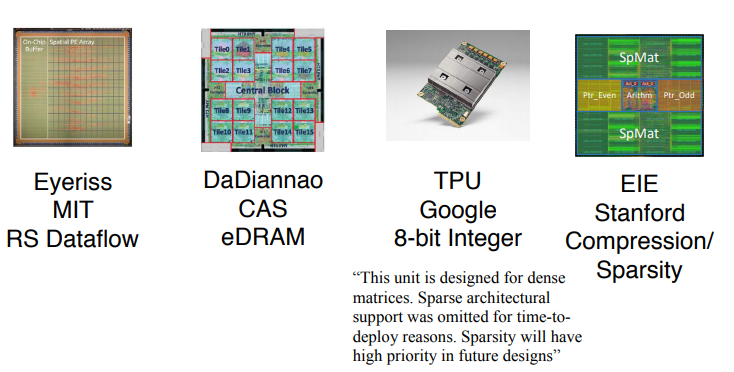

### 四. Algorithms for efficient  training

1. Parallelization 并行化
2. Mixed Precision with FP16 and FP32 混合进精度训练
3. Model Distillation 模型精馏
4. DSD: Dense-Sparse-Dense Training  密-稀-密训练。或者称为更好的正则化技术。

####  4.1 Parallelization 并行化

- Data Parallel 同时读入两张Image
    特点：
    1. 不会影响单张的处理速度
    2. 仅仅是增加了batch_size
    3. 需要权值的协同更新。

- Model-Parallel 
 - 卷积并行
 - FC并行
 - 超参数并行

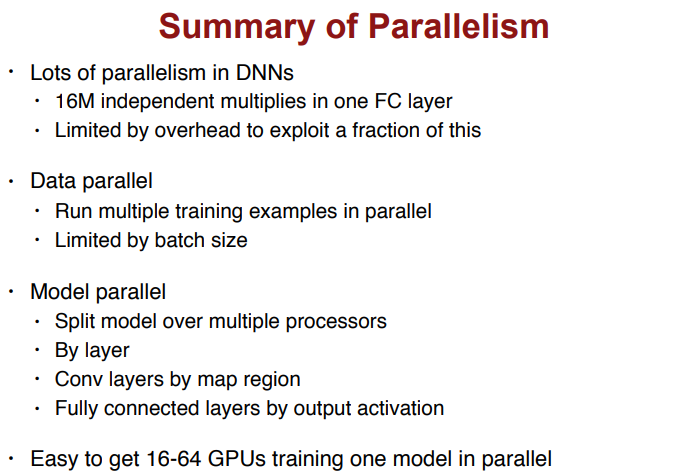

#### 2. Mixed Precision with FP16 and FP32  16位数和32位数的混合精度

乘法用16位，加法用32位，最终转为32位存储

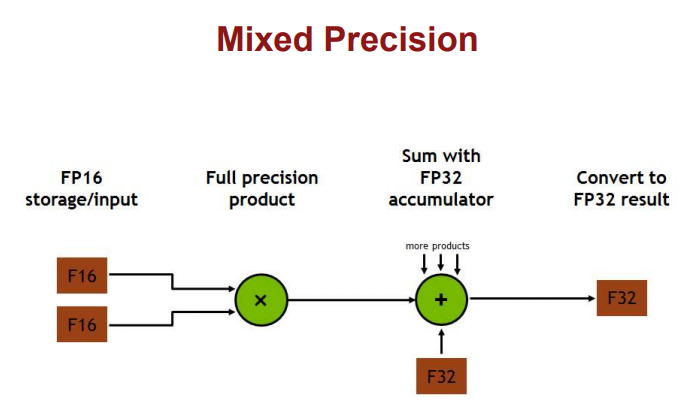

**<center> 图1. 图解<center>**

例子如下图所示。
对一个FP32 的数，先转换为FP16，然后前向传递，经过16位的权值得到16位的激活。接下来的反向传播也用16位计算。
在更新权重的时候用32位计算

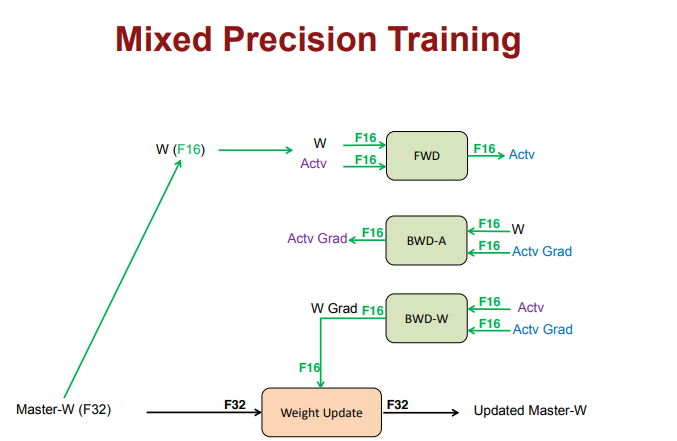

#### 3. Model Distillation 模型精馏

思想是能不能借鉴不同模型的有点，一个方面是做集成学习。另一方面是用这些网络做老师，教那些小的初级网络，使他们能做的更好。

实现的方法是不能用[0,1]这种硬标签，使用软标签学习

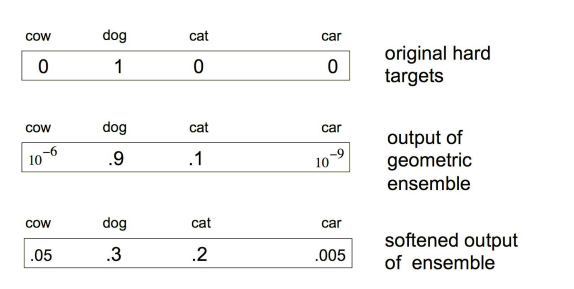

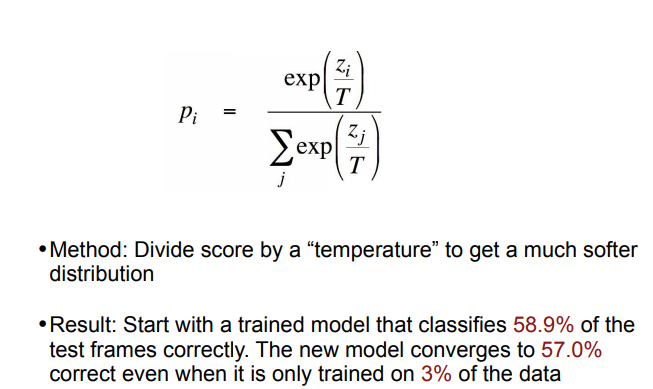

#### 4. DSD: Dense-Sparse-Dense Training

思想类比于，先训练树干，再接着训练叶子。全部一起学习

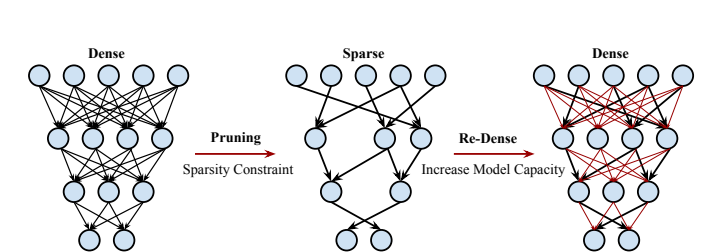

### 五. Hardware for Efficient Training 


#### GPU
